# Examples of reading data from the TIGRESS simulations - MHD datasets

**Welcome to the TIGRESS data release!**

This script focus on reading and analysing the original MHD dataset from the original TIGRESS simulation run by the Athena4.2 code ([Kim & Ostriker (2017)](https://ui.adsabs.harvard.edu/abs/2017ApJ...846..133K/abstract)).

In [2]:
import sys
sys.path.insert(0, "../module/")
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import tigress_read #scripts for reading data
import yt #https://yt-project.org/

## Examining the simulation model information

In [3]:
#master directory of where the data is stored
dir_master = "../data/" #this is default
model_id = "R8_2pc" #name of the simulation model

First, we can look into what snapshots are available, and what types of datasets they contain.

Each snapshot has an "ivtk" number. This is the Athena4.2 VTK output id. 

The time for each snapshot is ivtk*dt_Myr, where dt_Myr is the output interval per vtk number in Myr.

For the "R8_2pc" simulation, we release the data in the time frame when the simulation has already reached a steady state. The data release time interval is about 10 Myr.

In [4]:
#one can download a data snapshot using `download` method
#dataset can be one of ["MHD", "chem", "CO_lines", "history", "input", "all"]
model = tigress_read.Model(model_id, dir_master=dir_master) #reading the model information

**Download the data if you haven't done it yet**

In [5]:
#model.download(300,dataset="history")
#model.download(300,dataset="input")
#model.download(300,dataset="MHD")

In [6]:
print("Snapshots and contained data sets:")
for ivtk in model.ivtks:
    print("ivtk={:d}, t={:.1f} Myr, datasets={}".format(ivtk, ivtk*model.dt_Myr, model.data_sets[ivtk]))

Snapshots and contained data sets:
ivtk=300, t=293.3 Myr, datasets=['CO_lines', 'MHD', 'chem']


We can also look at the history output, which contains the overall information (such as the star formation rate) of the simulation as a function of time.

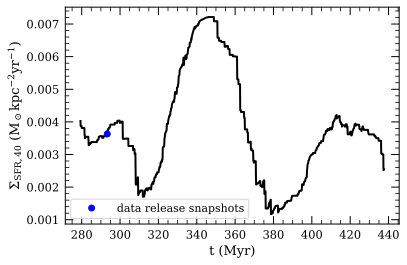

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
#star formation rate (averaged over 40 Myr)
ax.plot(model.hst["time"]*model.dt_Myr, model.hst["sfr40"], "k-")
#snapshots
f = interp1d(model.hst["time"]*model.dt_Myr, model.hst["sfr40"])
ax.plot(model.t_Myr, f(model.t_Myr), "bo", label="data release snapshots")
ax.legend()
ax.set_ylabel("$\Sigma_{SFR,40}\ (M_\odot kpc^{-2} yr^{-1})$")
ax.set_xlabel("t (Myr)");

## Read and analyze the 3D MHD simulation output

Now, we want to look into the detailed 3D simulation data of the simulations. First, we select a snapshot (identified by its ivtk number) and the type of dataset we want to look into ("MHD" in this case). Then we need to load the data. Because the data files are large, it can take a while to load.

In [8]:
#load the MHD data set for the snapshot ivtk=300
model.load(300, dataset="MHD")

Because we use the python package [YT](https://yt-project.org/) to read the outputs from the MHD simulation, the data stored in the YT format. This means that all fields (such as density, velocity, H2 and CO abundances) in the data has *units* atached. 

I will show you how to access these fields and convert them into numpy arrays later. But first, you can print out the information of all the fields available using the code below (I commented it because the output is too long).

In [9]:
#model.MHD.ytds.field_info

Let's start with an example reading the density field (the name of the field is simply "density").

In [10]:
density = model.MHD.grid["density"]
print("The dimensions of the 3D density field: Nx={:d}, Ny={:d}, Nz={:d}".format(
       density.shape[0], density.shape[1], density.shape[2]))
print("The first 3 elements of the density field (along the z axis): ", density[0, 0, :3])
print("Check the type of the variable: ", type(density))

/Users/munangong/opt/anaconda3/envs/astro-tigress/lib/python3.8/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'density' is ambiguous and corresponds to any one of the following field types:
 {'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "density")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)


The dimensions of the 3D density field: Nx=512, Ny=512, Nz=512
The first 3 elements of the density field (along the z axis):  [2.18841065e-26 3.13927415e-26 3.28632329e-26] g/cm**3
Check the type of the variable:  <class 'unyt.array.unyt_array'>


You can see that there is a *unit* "code_mass/code_length**3" attached to the density field, which has the type of a YT array. Of course, you want to convert it to a sensible physical unit, which you can do by:

In [11]:
print("The first 3 elements of the density field in physical units: ", 
      density[0, 0, :3].in_units("g/cm**3"))

The first 3 elements of the density field in physical units:  [2.18841065e-26 3.13927415e-26 3.28632329e-26] g/cm**3


### Convert data fields into numpy arrays

However, what you *really* want to do is to convert them into numpy arrays. You can do it with:

In [12]:
density_np = density.in_units("g/cm**3").value
print("Check the type of the variable: ", type(density_np))
print("The first 3 elements of the density field in physical units of g/cm**3, converted to numpy array: ", 
      density_np[0, 0, :3])

Check the type of the variable:  <class 'numpy.ndarray'>
The first 3 elements of the density field in physical units of g/cm**3, converted to numpy array:  [2.18841065e-26 3.13927415e-26 3.28632329e-26]


**Wola!**

We can now look at, for example, the density distribution.

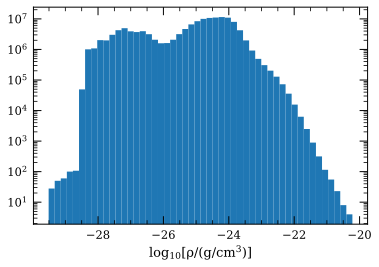

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(np.log10(density_np.reshape(-1)), bins=50);
ax.set_yscale("log")
ax.set_xlabel(r"$\log_{10}[\rho / (g/cm^3)]$");

### Use YT to analyse data

The "ytds" member is the standard yt data object. You can use all the standard YT function to plot and analyse the data.

Below is a vertical slice of the gas density. You can see that this set of simulation data release contains only the galactic mid-plane region. 


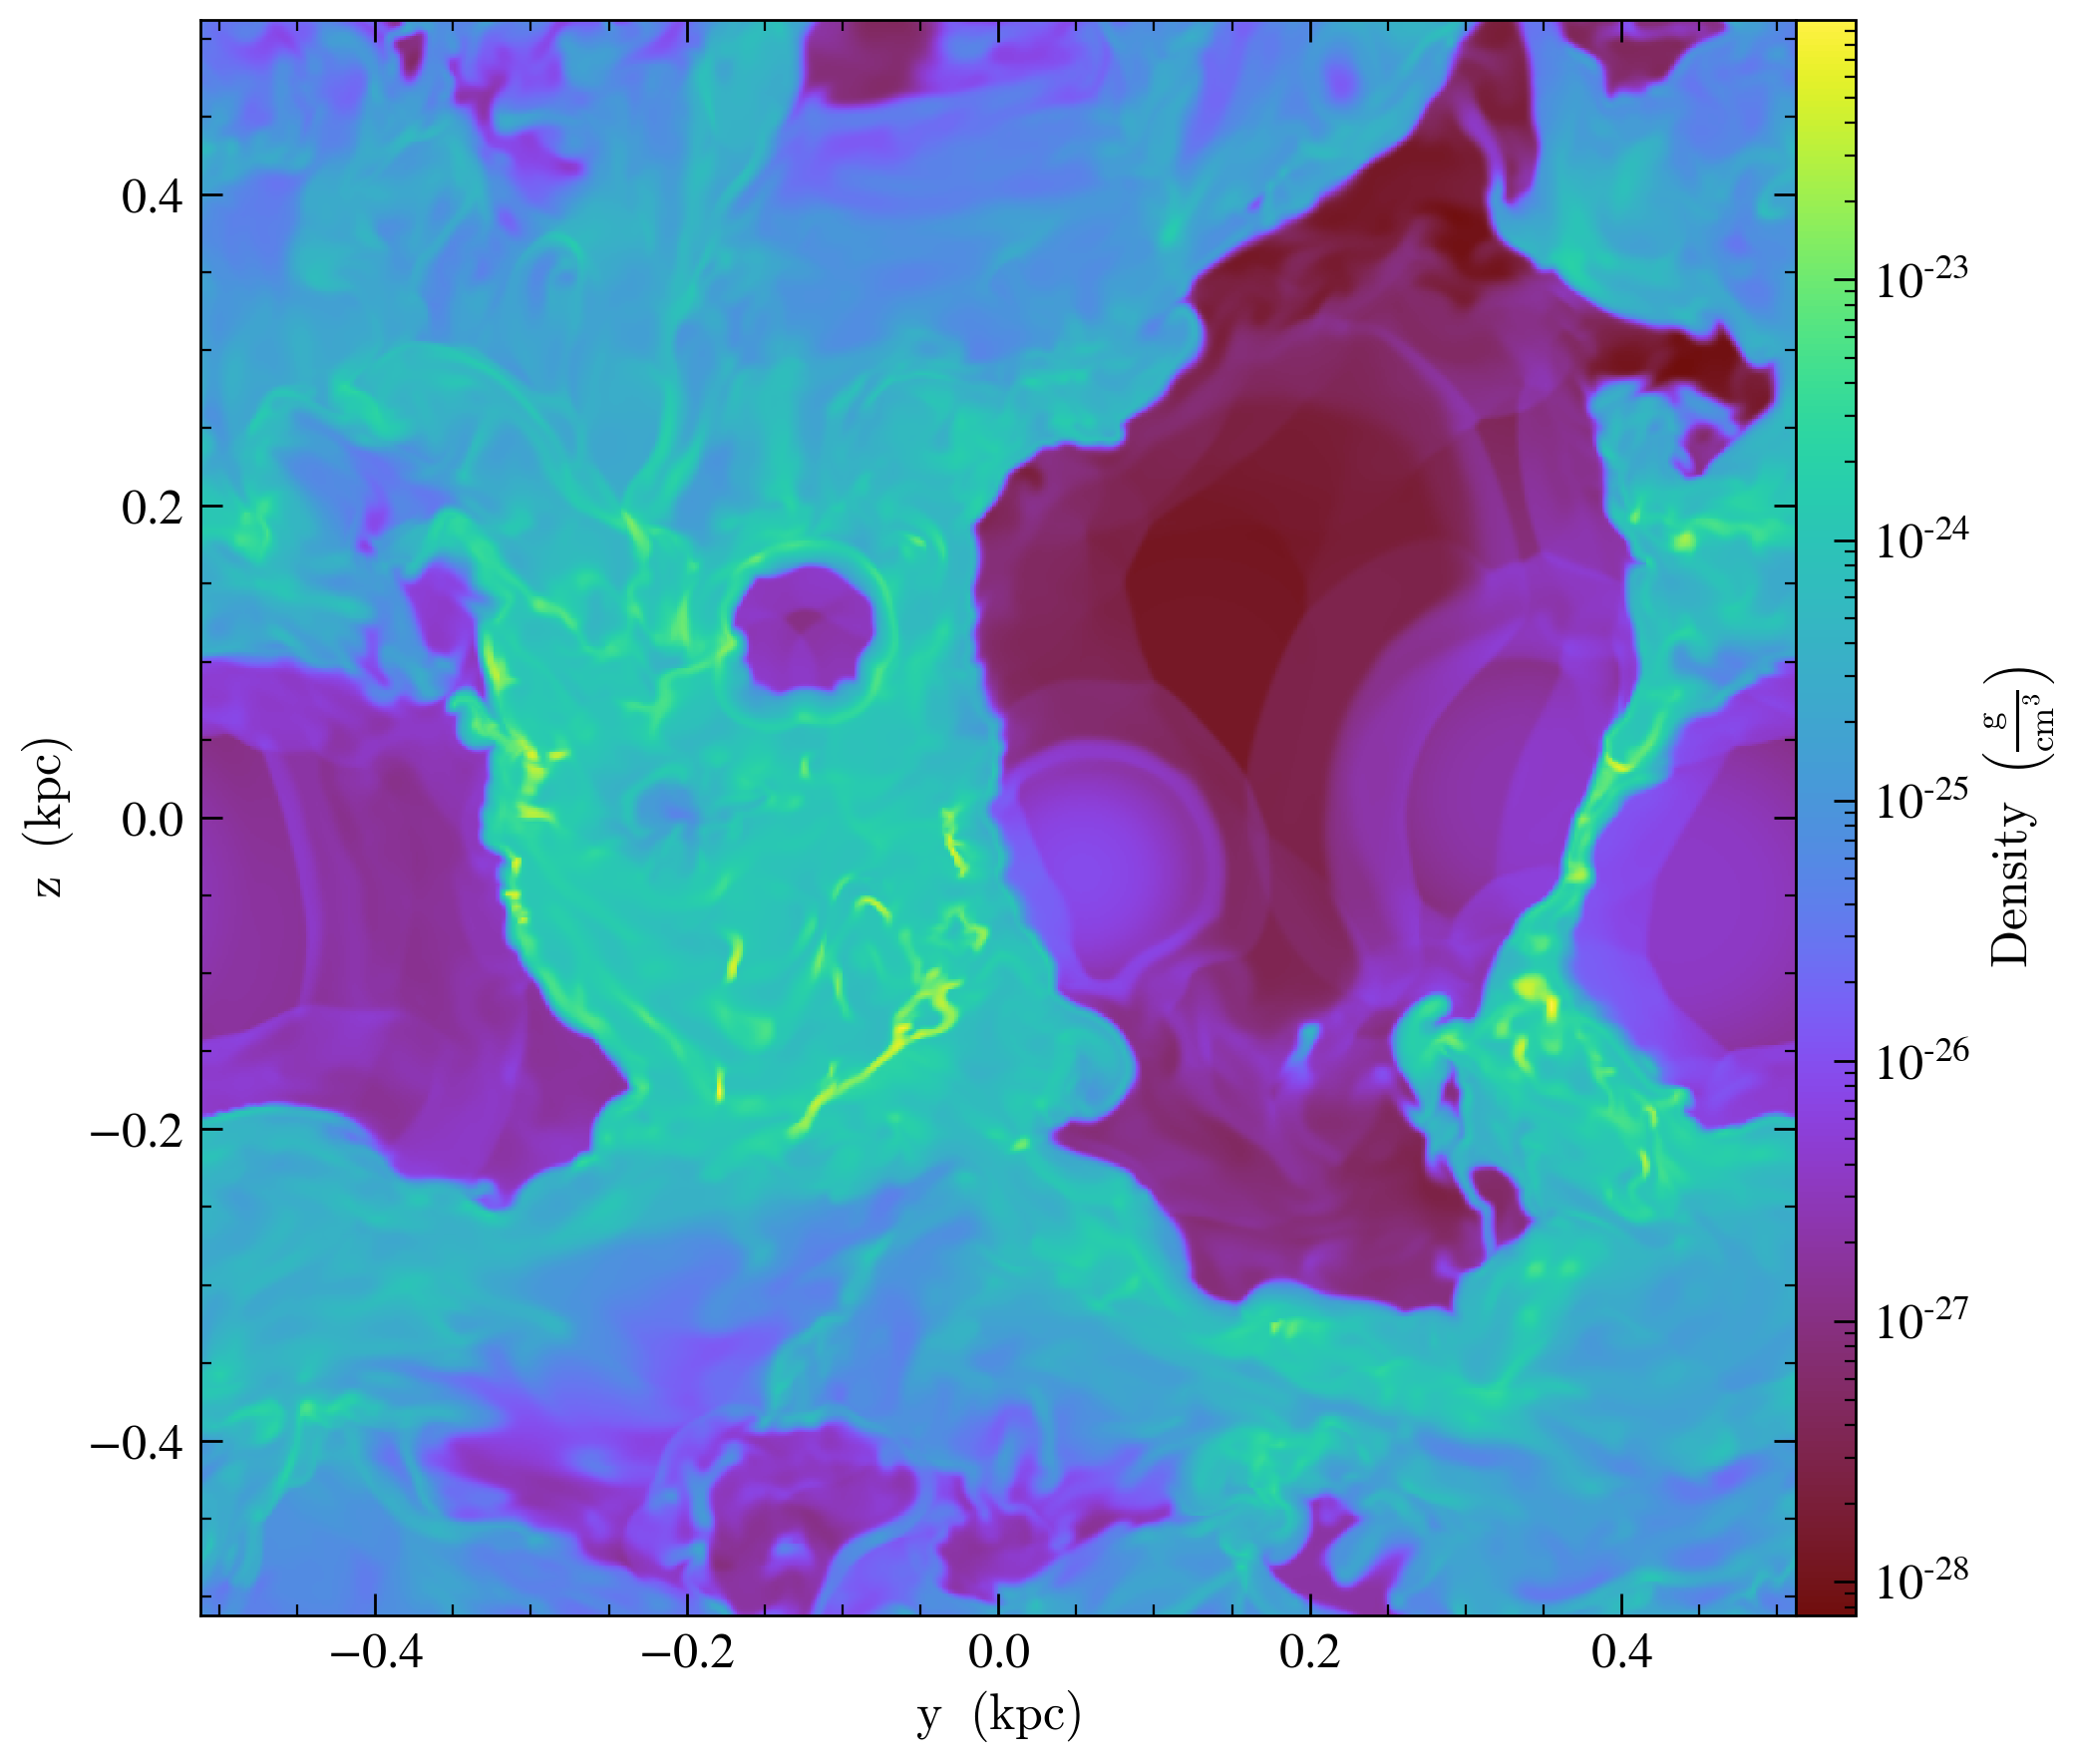

In [14]:
yt.SlicePlot(model.MHD.ytds, "x", ("gas", "density"))